Number of training images: 174
Number of validation images: 12
Total images: 186


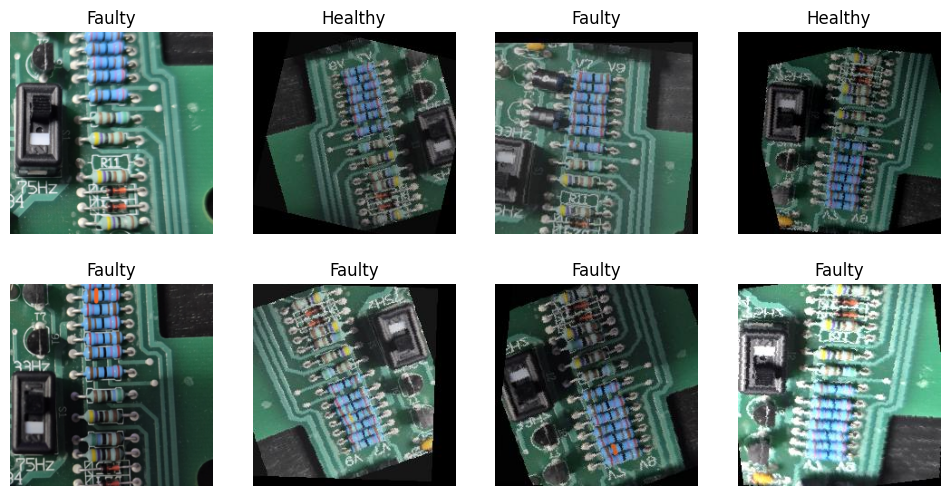

In [10]:
# === Imports ===
from fastai.vision.all import *
from pathlib import Path

# === Define Dataset Path ===
base_path = Path(r"D:\Cursor projects\Assignment2\Dataset_Circuitboard_augmented")

# === Define Helper Functions ===
def label_func(path):
    return path.parent.name

def is_valid_func(path):
    return any('validate' in part.lower() for part in path.parts)

# === Define DataBlock ===
circuitboard_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda path: get_image_files(path, recurse=True),
    splitter=FuncSplitter(is_valid_func),
    get_y=label_func,
    item_tfms=Resize(224)
)

# === Create DataLoaders Without Augmentation ===
dls = circuitboard_block.dataloaders(
    base_path,
    bs=8,
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats)
    ]
)

# === Print Dataset Summary ===
print(f"Number of training images: {len(dls.train_ds)}")
print(f"Number of validation images: {len(dls.valid_ds)}")
print(f"Total images: {len(dls.train_ds) + len(dls.valid_ds)}")

# === Visualize a Sample Batch ===
dls.show_batch(max_n=8)


In [11]:
# === Create a Vision Learner Using ResNet ===

learn = vision_learner(dls, 'resnet34', metrics=accuracy)

# === Train Entire Model with Fine-Tuning ===

learn.fine_tune(20, base_lr=1e-3)  # Handles freezing/unfreezing automatically

# === Evaluate Model ===

interp = ClassificationInterpretation.from_learner(learn)

# === Save the Trained Model ===

learn.export('circuitboard_classifier.pkl')


epoch,train_loss,valid_loss,accuracy,time
0,1.260964,0.813838,0.416667,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.019700,0.841686,0.416667,00:02
1,1.088835,0.849995,0.500000,00:02
2,1.196444,0.864181,0.500000,00:02
3,1.137563,0.794829,0.500000,00:02
4,1.109340,0.897480,0.500000,00:02
5,1.050269,0.933426,0.333333,00:02
6,1.000665,0.894222,0.500000,00:02
7,0.988276,0.878842,0.583333,00:02
8,0.897638,1.087905,0.500000,00:02
9,0.875288,1.035308,0.416667,00:02


Loading model from: circuitboard_classifier.pkl


d:\Cursor projects\Assignment2\venv\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


File: 20250422_200351.jpg | True: Healthy | Predicted: Faulty | Time: 0.1622 sec


File: 20250422_200356.jpg | True: Healthy | Predicted: Faulty | Time: 0.1296 sec


File: 20250422_200359.jpg | True: Healthy | Predicted: Faulty | Time: 0.1142 sec


File: 20250422_200404.jpg | True: Healthy | Predicted: Faulty | Time: 0.1351 sec


File: 20250422_200407.jpg | True: Healthy | Predicted: Faulty | Time: 0.1606 sec


File: 20250422_200409.jpg | True: Healthy | Predicted: Faulty | Time: 0.2632 sec


File: 20250422_200352.jpg | True: Faulty | Predicted: Healthy | Time: 0.1071 sec


File: 20250422_200409.jpg | True: Faulty | Predicted: Healthy | Time: 0.1300 sec


File: 20250422_200411.jpg | True: Faulty | Predicted: Healthy | Time: 0.1200 sec


File: 20250422_202539.jpg | True: Faulty | Predicted: Faulty | Time: 0.1171 sec


File: 20250422_202604.jpg | True: Faulty | Predicted: Faulty | Time: 0.1057 sec


File: 20250422_202609.jpg | True: Faulty | Predicted: Faulty | Time: 0.1092 sec
🧠 Model Source: circuitboard_classifier.pkl
✅ Validation Accuracy: 25.00% (3/12)
⚡ Avg Inference Time per Image: 0.1378 sec


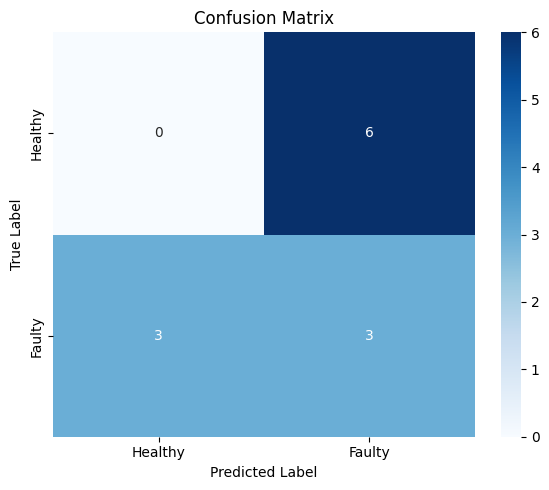

In [18]:
# === Imports ===
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.vision.all import load_learner
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Define Paths ===

base_path = Path(r"D:\Cursor projects\Assignment2\Dataset_Circuitboard")
validate_folder = base_path / "validate"
model_path = Path("circuitboard_classifier.pkl")

# === Load the Trained Model ===

print(f"Loading model from: {model_path}")
learn = load_learner(model_path)

# === Initialize Counters and Trackers ===

total = 0
correct = 0
inference_times = []
y_true = []
y_pred = []
class_names = ['Healthy', 'Faulty']

# === Perform Inference on Validation Set ===

for label in class_names:
    label_folder = validate_folder / label

    for image_filename in os.listdir(label_folder):
        if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = label_folder / image_filename

            # Time the inference
            start_time = time.perf_counter()
            pred_label, _, _ = learn.predict(image_path)
            end_time = time.perf_counter()

            inference_time = end_time - start_time
            inference_times.append(inference_time)

            # Accuracy Check
            if pred_label.lower() == label.lower():
                correct += 1
            total += 1

            y_true.append(label)
            y_pred.append(pred_label)

            # Print result
            print(f"File: {image_filename} | True: {label} | Predicted: {pred_label} | Time: {inference_time:.4f} sec")

# === Compute and Print Metrics ===

if total > 0:
    accuracy = correct / total * 100
    avg_time = sum(inference_times) / total
    print(f"🧠 Model Source: {model_path}")
    print(f"✅ Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")
    print(f"⚡ Avg Inference Time per Image: {avg_time:.4f} sec")

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("No validation images found.")
